## Marmousi 1

October 25, 2020

Let's start by trying to load in the velocity field from a Matlab file that we got from CREWES.


## Reading Matlab

Look here for details: https://scipy-cookbook.readthedocs.io/items/Reading_mat_files.html

In [1]:
from scipy.io import loadmat
mar_data = loadmat('marmousi_dz10.mat')
x = mar_data['x'][0]  ## x is stored as an array inside an array
z = mar_data['z'][0]  ## z also. So we take just the first entry. 
vel = mar_data['vel']

In [2]:
import matplotlib.pyplot as plt

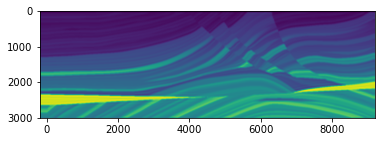

In [3]:
extent = (x[0], x[-1], z[-1], z[0])
plt.imshow(vel,extent=extent);

In [4]:
len(x)

941

In [5]:
len(z)

301

In [6]:
len(vel[0])

941

## Save data as JSON file

We are reading how to deal with JSON conversion here: 
- https://www.kite.com/python/answers/how-to-serialize-a-numpy-array-into-json-in-python
- https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/

In [7]:
import json
import numpy as np

## Here is an example of a json dump to covert data to a string
print(json.dumps({"name": "John", "age": 30}))

{"name": "John", "age": 30}


In [8]:
## Here we can look at the x variable from the file read. 
## Notice this is a string, represetning a 1D array
print(json.dumps(x.tolist()))

[-200, -190, -180, -170, -160, -150, -140, -130, -120, -110, -100, -90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630, 1640, 1650, 166

## Important
I had to edit the files x.json, z.json, vel.json to include "vel = " at the beginning, so that JS will read it in propoerly.

## Javascript

Here is the javascript. It's pretty complicated, and tough to debug. Sorry. 

In [13]:
%%html
<html><head id="Barebones">
        <meta charset="UTF-8" />
        <meta name="viewport" content="width=device-width, initial-scale=1.0" />
        <script src="GPGPUtility.js"></script>
        <script src="WaveEqn.js"></script>
        <script src="WavePlot.js"></script>
        <script src="vel.json"></script>        
        <title>WebGL wave example</title>
        </head>
        <body>
               
        <div class="content">
            <h1>Marmousi Model: a refracting wave packet. </h1>
              <label for="x0">Xo (m)</label>
              <input type="number" id="x0" name="x0name" value = 7500>
              <label for="y0">Yo (m)</label>
              <input type="number" id="y0" name="y0name" value= 8000>
              <label for="angle">Angle (deg)</label>
              <input type="number" id="angle" name="anglename" value=-30>
              <label for="width">Width (m)</label>
              <input type="number" id="width" name="widthname" value=100>
              <input type="submit" id="restartbutton" value="Restart">
 

            <figure class="center" id="results">
                <figcaption>
                    You should see a waveform traveling here. 
                </figcaption>
            </figure>
        </div>

        
        <script>
            "use strict";

            /** The canvas onto which we render the wave function & potential */
            var canvas;
            var dt;
            var gl;
            var gpgpUtility;
            var nframes;
            var nsteps;
            var parent;
            var renderer;
            var vel_top;
            var vel_bot;
            var wp;
            var wt;
            var wlen;
            var wang;
            var waveengine;
            var waveFunctionData, waveFunctionDataD, waveFunctionTexture0, waveFunctionTexture1, waveFunctionTexture2;
            var x0;
            var y0;
            var xLength;
            var xResolution;
            var yLength;
            var yResolution;


            // Physical parameters for the wave motion simulation
            
            xLength = 10000.0; // in meters (10x1000 for marmousi)
            yLength = 10000.0; // in meters
            wp = 0.05*xLength; // width of the initial Gaussian wave, propagating direction
            wt = 0.05*xLength; // width of the initial Gaussian wave, transverse direction
            wlen = .05*xLength; // wavelength of the propagating wave
            // the following will get changed in the UI. These are typical values
            vel_top = 500.0; // velocity in m/s, in top half
            vel_bot = 1000.0; // velocity in m/s, in bottom half
            x0 = .25*xLength; // location of initial Gaussian
            y0 = .75*yLength;
            wang = 30; // propagation angle in degrees (0 normal incidence)

            // Parameters for the numerical simulation
            
            xResolution = 1000; // number of sample points (x-dir y-dir)
            yResolution = 1000; 
            dt = .0005; // sample interval for time, in seconds
            nframes = 1000; // Total number of frames to compute and display
            nsteps = 5; // Number of delta t timesteps per frame
            
            //
            var local_vel = vel_; // this grabs an array of velocity values that was in file vel.json

            // Setup the GPU and canvas to display results
            
            gpgpUtility = new vizit.utility.GPGPUtility(xResolution, yResolution, {premultipliedAlpha: false});
            gpgpUtility.setProblemSize(xResolution, yResolution);

            canvas = gpgpUtility.getCanvas();
            canvas.style.height = yResolution + "px";
            parent = document.getElementById("results")
            parent.insertBefore(canvas, parent.firstChild);
            
            // setup the numerical parts
            
            // we stuff velocity squared info into the green channel, for easy access to the GPU
            function velField2(waveform,xRez,yRez) {
                for (var j = 0; j < yRez; ++j) {
                    for (var i = 0; i < xRez; ++i) {
                        waveform[4*(i + j*xRez) + 1] = 
                            (j > yRez/2) ? vel_top**2 : vel_bot**2;
                    }
                }
                return waveform;
            }
        
             // we read in a json file with velocities
            // then stuff velocity squared info into the green channel, for easy access to the GPU
            function velField(waveform,xRez,yRez) {
                // i is the x coordinate, j the y coordinate in the 1000x1000 grid
                // ii,jj index into marmousi data 0 <= ii <= 901, 0 <= jj <= 301
                for (var j = 0; j < 1000; ++j) {
                    for (var i = 0; i < 1000; ++i) {
                        var ii = Math.max(0, Math.min(900,i- 50));
                        var jj = Math.max(0, Math.min(300,j-200));
                        waveform[4*(i + (999-j)*xRez) + 1] = .25*local_vel[jj][ii]**2;
                    }
                }
                return waveform;
            }
        
            // an initial plane wave of wavelength lambda, constrained to a window of width w
            function f_plane(x,w,lambda) {
                return Math.exp(-(x*x)/(w*w))*Math.cos(2*Math.PI*x/lambda);
            }
            // the corresponding derivative
            function f_planeD(x,w,lambda) {
                return -Math.exp(-(x*x)/(w*w))*((2*x/(w*w))*Math.cos(2*Math.PI*x/lambda)+
                                                (2*Math.PI/lambda)*Math.sin(2*Math.PI*x/lambda));
            }
            // a window in the transverse direction, width is w
            function f_win(y,w) {
                return Math.exp(-(y*y)/(w*w));
            }
            // the corresponding derivative
            function f_winD(y,w) {
                return -Math.exp(-(y*y)/(w*w))*(2*y/(w*w));
            }
 
            // the initial waveform
            function gaussWaveform(waveform,xRez,yRez,xLen,yLen) {
                var aa = Math.sin(Math.PI*wang/180); // rotation matrix
                var bb = -Math.cos(Math.PI*wang/180);
                for (var j = 0; j < yRez; ++j) {
                    for (var i = 0; i < xRez; ++i) {
                        var x = xLen*(i/xRez) - x0;
                        var y = yLen*(j/yRez) - y0;
                        waveform[4*(i + j*xRez)] = 
                             10*f_plane(aa*x + bb*y,wp,wlen)*f_win(-bb*x+aa*y,wt);
                      }
                }
                return waveform;
            }
            
            // the derivative. Note we need to use velocities stored in the Green channel
            function gaussWaveformD(waveform,xRez,yRez,xLen,yLen) {
                var aa = Math.sin(Math.PI*wang/180); // rotation matrix
                var bb = -Math.cos(Math.PI*wang/180);
                for (var j = 0; j < yRez; ++j) {
                    for (var i = 0; i < xRez; ++i) {
                        var x = xLen*(i/xRez) - x0;
                        var y = yLen*(j/yRez) - y0;
                        var vel = Math.sqrt(waveform[4*(i + j*xRez) + 1]);
                        waveform[4*(i + j*xRez)] = 
                             10*f_plane(aa*x + bb*y,wp,wlen)*f_win(-bb*x+aa*y,wt)
                                - 10*dt*vel*f_planeD(aa*x + bb*y,wp,wlen)*f_win(-bb*x+aa*y,wt);
                      }
                }
                return waveform;
            }

            /*
             * Run the simulation for n time steps, then show the results.
            */
            function nextFrame() {
                for (var i = 0; i < nsteps; ++i) {
                    waveengine.timestep();
                }

                renderer.show(waveengine.getRenderedTexture());
                nframes--;
                if (nframes>0) {
                    requestAnimationFrame(nextFrame);
                }
            }
            
            function setup_and_run(init_x, init_y, init_angle, init_width) { 
                //  Global variables set up for the initialization of the wave packet.
            
                // Initial angle of incidence, and center of wave packet
                wang = init_angle;  
                x0 = init_x;
                y0 = init_y;
                
                // width of the wave packet
                wp = init_width;
                wt = init_width;
                wlen = init_width;
            
                // setup the velocity values
                //vel_top = init_vel_top; // velocity in m/s, in top half
                //vel_bot = init_vel_bot; // velocity in m/s, in bottom half

                // setup the initial data arrays
                waveFunctionData = new Float32Array(4 * xResolution * yResolution);
                waveFunctionData = velField(waveFunctionData,xResolution,yResolution);
                waveFunctionData = gaussWaveform(waveFunctionData,xResolution,yResolution,xLength,yLength);
 
                waveFunctionDataD = new Float32Array(4 * xResolution * yResolution);
                waveFunctionDataD = velField(waveFunctionDataD,xResolution,yResolution);
                waveFunctionDataD = gaussWaveformD(waveFunctionDataD,xResolution,yResolution,xLength,yLength);
 
                // put the data arrays into the GPU tecture structures
                waveFunctionTexture0 = gpgpUtility.makeTexture(WebGLRenderingContext.FLOAT, waveFunctionData);
                waveFunctionTexture1 = gpgpUtility.makeTexture(WebGLRenderingContext.FLOAT, waveFunctionDataD);
                waveFunctionTexture2 = gpgpUtility.makeTexture(WebGLRenderingContext.FLOAT, waveFunctionData);

                // setup the GPU engine and get it running
                waveengine = new WaveEngine(gpgpUtility, xResolution, yResolution, xLength, yLength, dt);
                renderer = new WaveResults(gpgpUtility, parent, xResolution, yResolution);

                waveengine.setInitialTextures(waveFunctionTexture0, waveFunctionTexture1, waveFunctionTexture2);

                renderer.show(waveengine.getRenderedTexture(),4000.0**2);
                
                nframes = 2000;  // the number of frames we run and show
                requestAnimationFrame(nextFrame);
            }
            setup_and_run(
                document.getElementById("x0").value,
                document.getElementById("y0").value,
                document.getElementById("angle").value, 
                document.getElementById("width").value 
            );
            
    </script>
    
    <br class="clear" />
        <script>
        restartbutton.addEventListener('click', function (ev) {
            waveengine.done();
            // sanity checks on UI elements
            if (document.getElementById("x0").value < 0) {
                document.getElementById("x0").value = 0;
            }
            if (document.getElementById("x0").value > 9000) {
                document.getElementById("x0").value = 9000;
            }
            if (document.getElementById("y0").value < 0) {
                document.getElementById("y0").value = 0;
            }
            if (document.getElementById("y0").value >  9000) {
                document.getElementById("y0").value =  9000;
            }
            if (document.getElementById("angle").value < -360) {
                document.getElementById("angle").value = -360;
            }
            if (document.getElementById("angle").value >  720) {
                document.getElementById("angle").value =  720;
            }
            if (document.getElementById("width").value < 1) {
                document.getElementById("width").value = 1;
            }
            if (document.getElementById("width").value >  100) {
                document.getElementById("width").value =  100;
            }
            setup_and_run(
                document.getElementById("x0").value,
                document.getElementById("y0").value,
                document.getElementById("angle").value, 
                document.getElementById("width").value 
            );
            
        }, false);
        </script>

</html>

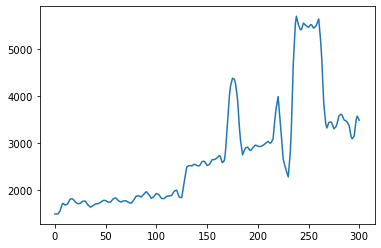

In [12]:
plt.plot(vel[:,50]);